# Linear Regression

In this tutorial we'll walk through how one can implement *linear regression* using MXNet APIs.

The function we are trying to learn is: *y = x<sub>1</sub>  +  2x<sub>2</sub>*, where *(x<sub>1</sub>,x<sub>2</sub>)* are input features and *y* is the corresponding label.

## Prerequisites

To complete this tutorial, we need:

- MXNet. See the instructions for your operating system in [Setup and Installation](http://mxnet.io/install/index.html).

- [Jupyter Notebook](http://jupyter.org/index.html).

```
$ pip install jupyter
```

To begin, the following code imports the necessary packages we'll need for this exercise.

In [1]:
import mxnet as mx
import numpy as np

# Fix the random seed
mx.random.seed(42)

import logging
logging.getLogger().setLevel(logging.DEBUG)

In [2]:
#get data
import pandas as pd
data=pd.read_csv("../kaggle/train.csv")

number_feature_index=data.iloc[:,1:].dtypes[data.iloc[:,1:].dtypes !='object'].index
data[number_feature_index] = data[number_feature_index].apply(lambda x:(x-x.mean())/x.std())
data = data.fillna(data.mean())
feature = data.iloc[:,1:-1]
label = data.iloc[:,-1]

feature = pd.get_dummies(feature,dummy_na=True)

print(feature.iloc[0:4])
print(label.iloc[0:4])


   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.073350    -0.207948 -0.207071     0.651256    -0.517023   1.050634   
1   -0.872264     0.409724 -0.091855    -0.071812     2.178881   0.156680   
2    0.073350    -0.084413  0.073455     0.651256    -0.517023   0.984415   
3    0.309753    -0.413838 -0.096864     0.651256    -0.517023  -1.862993   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2        ...          \
0      0.878367    0.509840    0.575228   -0.288554        ...           
1     -0.429430   -0.572637    1.171591   -0.288554        ...           
2      0.829930    0.322063    0.092875   -0.288554        ...           
3     -0.720051   -0.572637   -0.499103   -0.288554        ...           

   SaleType_Oth  SaleType_WD  SaleType_nan  SaleCondition_Abnorml  \
0             0            1             0                      0   
1             0            1             0                      0   
2             0            1        

Once we have the data ready, we need to put it into an iterator and specify
parameters such as `batch_size` and `shuffle`. `batch_size` specifies the number
of examples shown to the model each time we update its parameters and `shuffle`
tells the iterator to randomize the order in which examples are shown to the model.

In [3]:
from mxnet import nd
import mxnet as mx

train_features = nd.array(feature.values)
train_labels = nd.array(label.values)

split_train = int(len(train_features) * 0.8)

batch_size = 1
train_iter = mx.io.NDArrayIter(train_features[:split_train,0:3], train_labels.reshape(-1,)[0:split_train], batch_size, shuffle=True,label_name='lin_reg_label')
eval_iter = mx.io.NDArrayIter(train_features[split_train,0:3], train_labels.reshape(-1,)[split_train:],  batch_size,shuffle=False,label_name='lin_reg_label')


In [4]:
#train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True, label_name='lin_reg_label')
#eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False, label_name='lin_reg_label')

In the above example, we have made use of `NDArrayIter`, which is useful for iterating
over both numpy ndarrays and MXNet NDArrays. In general, there are different types of iterators in
MXNet and you can use one based on the type of data you are processing.
Documentation for iterators can be found [here](http://mxnet.io/api/python/io/io.html).

## MXNet Classes

1. **IO:** The IO class as we already saw works on the data and carries out
   operations such as feeding data in batches and shuffling.

2. **Symbol:** The actual MXNet neural network is composed using symbols. MXNet has
   different types of symbols, including variable placeholders for input data,
   neural network layers, and operators that manipulate NDArrays.

3. **Module:** The module class in MXNet is used to define the overall computation.
	It is initialized with the model we want to train, the training inputs (data and labels)
	and some additional parameters such as learning rate and the optimization
	algorithm to use.

## Defining the Model

MXNet uses **Symbols** for defining a model. Symbols are the building blocks
and make up various components of the model. Symbols are used to define:

1. **Variables:** A variable is a placeholder for future data. This symbol is used
   to define a spot which will be filled with training data/labels in the future
   when we commence training.
2. **Neural Network Layers:** The layers of a network or any other type of model are
   also defined by Symbols. Such a symbol takes one or more previous symbols as
   inputs, performs some transformations on them, and creates one or more outputs.
   One such example is the `FullyConnected` symbol which specifies a fully connected
   layer of a neural network.
3. **Outputs:** Output symbols are MXNet's way of defining a loss. They are
   suffixed with the word "Output" (eg. the `SoftmaxOutput` layer). You can also
   [create your own loss function](https://github.com/dmlc/mxnet/blob/master/docs/tutorials/r/CustomLossFunction.md#how-to-use-your-own-loss-function).
   Some examples of existing losses are: `LinearRegressionOutput`, which computes
   the l2-loss between it's input symbol and the labels provided to it;
   `SoftmaxOutput`, which computes the categorical cross-entropy.

The ones described above and other symbols are chained together with the output of
one symbol serving as input to the next to build the network topology. More information
about the different types of symbols can be found [here](http://mxnet.io/api/python/symbol/symbol.html).

In [5]:
X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer  = mx.sym.FullyConnected(data=X, name='fc1', num_hidden = 1)
lro = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name="lro")

The above network uses the following layers:

1. `FullyConnected`: The fully connected symbol represents a fully connected layer
   of a neural network (without any activation being applied), which in essence,
   is just a linear regression on the input attributes. It takes the following
   parameters:

   - `data`: Input to the layer (specifies the symbol whose output should be fed here)
   - `num_hidden`: Number of hidden neurons in the layer, which is same as the dimensionality
     of the layer's output

2. `LinearRegressionOutput`: Output layers in MXNet compute training loss, which is
	the measure of inaccuracy in the model's predictions. The goal of training is to minimize the
	training loss. In our example, the `LinearRegressionOutput` layer computes the *l2* loss against
	its input and the labels provided to it. The parameters to this layer are:

   - `data`: Input to this layer (specifies the symbol whose output should be fed here)
   - `label`: The training labels against which we will compare the input to the layer for calculation of l2 loss

**Note on naming convention:** the label variable's name should be the same as the
`label_name` parameter passed to your training data iterator. The default value of
this is `softmax_label`, but we have updated it to `lin_reg_label` in this
tutorial as you can see in `Y = mx.symbol.Variable('lin_reg_label')` and
`train_iter = mx.io.NDArrayIter(..., label_name='lin_reg_label')`.

Finally, the network is input to a *Module*, where we specify the symbol
whose output needs to be minimized (in our case, `lro` or the `lin_reg_output`), the
learning rate to be used while optimization and the number of epochs we want to
train our model for.

In [6]:
model = mx.mod.Module(
    symbol = lro ,
    data_names=['data'],
    label_names = ['lin_reg_label']# network structure
)

We can visualize the network we created by plotting it:

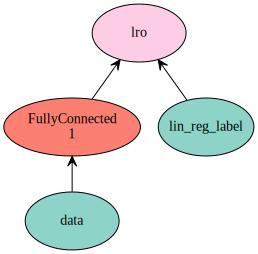

In [7]:
mx.viz.plot_network(symbol=lro, node_attrs={"shape":"oval","fixedsize":"false"})

## Training the model

Once we have defined the model structure, the next step is to train the
parameters of the model to fit the training data. This is accomplished using the
`fit()` function of the `Module` class.

In [ ]:
model.fit(train_iter, eval_iter,
            optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
            num_epoch=2,
            eval_metric='mse',
            batch_end_callback = mx.callback.Speedometer(batch_size, 2))

INFO:root:Epoch[0] Batch [2]	Speed: 1760.83 samples/sec	mse=0.089610
INFO:root:Epoch[0] Batch [4]	Speed: 681.83 samples/sec	mse=2.051675
INFO:root:Epoch[0] Batch [6]	Speed: 815.30 samples/sec	mse=1.877085
INFO:root:Epoch[0] Batch [8]	Speed: 859.75 samples/sec	mse=14.661506
INFO:root:Epoch[0] Batch [10]	Speed: 1465.26 samples/sec	mse=0.931724
INFO:root:Epoch[0] Batch [12]	Speed: 1275.25 samples/sec	mse=0.952107
INFO:root:Epoch[0] Batch [14]	Speed: 1727.83 samples/sec	mse=1.174589
INFO:root:Epoch[0] Batch [16]	Speed: 1301.57 samples/sec	mse=1.366732
INFO:root:Epoch[0] Batch [18]	Speed: 1328.78 samples/sec	mse=0.687609
INFO:root:Epoch[0] Batch [20]	Speed: 1449.06 samples/sec	mse=0.862074
INFO:root:Epoch[0] Batch [22]	Speed: 1528.26 samples/sec	mse=1.025365
INFO:root:Epoch[0] Batch [24]	Speed: 1163.15 samples/sec	mse=1.201889
INFO:root:Epoch[0] Batch [26]	Speed: 1206.82 samples/sec	mse=9.459662
INFO:root:Epoch[0] Batch [28]	Speed: 1442.08 samples/sec	mse=0.775049
INFO:root:Epoch[0] Batch [

INFO:root:Epoch[0] Batch [236]	Speed: 1932.86 samples/sec	mse=0.039423
INFO:root:Epoch[0] Batch [238]	Speed: 2011.66 samples/sec	mse=1.020016
INFO:root:Epoch[0] Batch [240]	Speed: 2018.92 samples/sec	mse=1.677592
INFO:root:Epoch[0] Batch [242]	Speed: 1965.93 samples/sec	mse=0.862371
INFO:root:Epoch[0] Batch [244]	Speed: 2030.65 samples/sec	mse=1.926708
INFO:root:Epoch[0] Batch [246]	Speed: 1971.01 samples/sec	mse=1.292573
INFO:root:Epoch[0] Batch [248]	Speed: 2033.60 samples/sec	mse=3.797442
INFO:root:Epoch[0] Batch [250]	Speed: 1925.32 samples/sec	mse=77.360040
INFO:root:Epoch[0] Batch [252]	Speed: 2006.84 samples/sec	mse=0.151766
INFO:root:Epoch[0] Batch [254]	Speed: 1923.99 samples/sec	mse=0.254432
INFO:root:Epoch[0] Batch [256]	Speed: 2002.53 samples/sec	mse=3.952615
INFO:root:Epoch[0] Batch [258]	Speed: 1994.91 samples/sec	mse=2.714131
INFO:root:Epoch[0] Batch [260]	Speed: 2028.19 samples/sec	mse=3.936475
INFO:root:Epoch[0] Batch [262]	Speed: 1926.20 samples/sec	mse=30.601800
INFO

INFO:root:Epoch[0] Batch [466]	Speed: 1913.46 samples/sec	mse=2.270202
INFO:root:Epoch[0] Batch [468]	Speed: 1899.16 samples/sec	mse=1.443903
INFO:root:Epoch[0] Batch [470]	Speed: 1895.30 samples/sec	mse=0.605945
INFO:root:Epoch[0] Batch [472]	Speed: 1954.93 samples/sec	mse=0.868516
INFO:root:Epoch[0] Batch [474]	Speed: 1966.39 samples/sec	mse=0.983306
INFO:root:Epoch[0] Batch [476]	Speed: 1924.43 samples/sec	mse=33.066097
INFO:root:Epoch[0] Batch [478]	Speed: 1998.24 samples/sec	mse=0.692832
INFO:root:Epoch[0] Batch [480]	Speed: 1948.57 samples/sec	mse=2.122031
INFO:root:Epoch[0] Batch [482]	Speed: 1997.76 samples/sec	mse=1.620945
INFO:root:Epoch[0] Batch [484]	Speed: 1953.11 samples/sec	mse=0.933920
INFO:root:Epoch[0] Batch [486]	Speed: 1971.01 samples/sec	mse=1.064744
INFO:root:Epoch[0] Batch [488]	Speed: 1976.58 samples/sec	mse=0.315634
INFO:root:Epoch[0] Batch [490]	Speed: 1977.98 samples/sec	mse=0.870186
INFO:root:Epoch[0] Batch [492]	Speed: 1950.39 samples/sec	mse=0.038817
INFO:

INFO:root:Epoch[0] Batch [698]	Speed: 1944.96 samples/sec	mse=0.392573
INFO:root:Epoch[0] Batch [700]	Speed: 1900.89 samples/sec	mse=1.033787
INFO:root:Epoch[0] Batch [702]	Speed: 1901.32 samples/sec	mse=0.143318
INFO:root:Epoch[0] Batch [704]	Speed: 1955.84 samples/sec	mse=0.231267
INFO:root:Epoch[0] Batch [706]	Speed: 2012.14 samples/sec	mse=0.149293
INFO:root:Epoch[0] Batch [708]	Speed: 1980.31 samples/sec	mse=0.614997
INFO:root:Epoch[0] Batch [710]	Speed: 1972.40 samples/sec	mse=0.026572
INFO:root:Epoch[0] Batch [712]	Speed: 1992.54 samples/sec	mse=0.473687
INFO:root:Epoch[0] Batch [714]	Speed: 2000.14 samples/sec	mse=1.152543
INFO:root:Epoch[0] Batch [716]	Speed: 1961.33 samples/sec	mse=0.061325
INFO:root:Epoch[0] Batch [718]	Speed: 2004.45 samples/sec	mse=0.772293
INFO:root:Epoch[0] Batch [720]	Speed: 1681.08 samples/sec	mse=1.566614
INFO:root:Epoch[0] Batch [722]	Speed: 2003.49 samples/sec	mse=0.034142
INFO:root:Epoch[0] Batch [724]	Speed: 1850.16 samples/sec	mse=0.038678
INFO:r

INFO:root:Epoch[0] Batch [930]	Speed: 2015.04 samples/sec	mse=0.680118
INFO:root:Epoch[0] Batch [932]	Speed: 1934.20 samples/sec	mse=0.369196
INFO:root:Epoch[0] Batch [934]	Speed: 1983.59 samples/sec	mse=1.308147
INFO:root:Epoch[0] Batch [936]	Speed: 1989.71 samples/sec	mse=0.155696
INFO:root:Epoch[0] Batch [938]	Speed: 2031.63 samples/sec	mse=0.735692
INFO:root:Epoch[0] Batch [940]	Speed: 2010.21 samples/sec	mse=0.915401
INFO:root:Epoch[0] Batch [942]	Speed: 2028.68 samples/sec	mse=0.204250
INFO:root:Epoch[0] Batch [944]	Speed: 1997.76 samples/sec	mse=0.032799
INFO:root:Epoch[0] Batch [946]	Speed: 1486.02 samples/sec	mse=0.426013
INFO:root:Epoch[0] Batch [948]	Speed: 2014.07 samples/sec	mse=1.899968
INFO:root:Epoch[0] Batch [950]	Speed: 1999.19 samples/sec	mse=0.518730
INFO:root:Epoch[0] Batch [952]	Speed: 2019.40 samples/sec	mse=0.364446
INFO:root:Epoch[0] Batch [954]	Speed: 1961.33 samples/sec	mse=3.384196
INFO:root:Epoch[0] Batch [956]	Speed: 2004.45 samples/sec	mse=0.055075
INFO:r

INFO:root:Epoch[0] Batch [1158]	Speed: 1955.84 samples/sec	mse=0.913669
INFO:root:Epoch[0] Batch [1160]	Speed: 1914.77 samples/sec	mse=0.472882
INFO:root:Epoch[0] Batch [1162]	Speed: 2017.95 samples/sec	mse=0.566710
INFO:root:Epoch[0] Batch [1164]	Speed: 1923.99 samples/sec	mse=0.283692
INFO:root:Epoch[0] Batch [1166]	Speed: 1959.96 samples/sec	mse=0.297068
INFO:root:Epoch[0] Train-mse=0.235229
INFO:root:Epoch[0] Time cost=1.221


## Using a trained model: (Testing and Inference)

Once we have a trained model, we can do a couple of things with it - we can either
use it for inference or we can evaluate the trained model on test data. The latter is shown below:

In [ ]:
model.predict(eval_iter).asnumpy()

We can also evaluate our model according to some metric. In this example, we are
evaluating our model's mean squared error (MSE) on the evaluation data.

In [ ]:
metric = mx.metric.MSE()
mse = model.score(eval_iter, metric)
print("Achieved {0:.6f} validation MSE".format(mse[0][1]))
assert model.score(eval_iter, metric)[0][1] < 0.01001, "Achieved MSE (%f) is larger than expected (0.01001)" % model.score(eval_iter, metric)[0][1]

Let us try and add some noise to the evaluation data and see how the MSE changes:

In [ ]:
eval_data = np.array([[7,2],[6,10],[12,2]])
eval_label = np.array([11.1,26.1,16.1]) #Adding 0.1 to each of the values
eval_iter = mx.io.NDArrayIter(eval_data, eval_label, batch_size, shuffle=False, label_name='lin_reg_label')
model.score(eval_iter, metric)


We can also create a custom metric and use it to evaluate a model. More
information on metrics can be found in the [API documentation](http://mxnet.incubator.apache.org/api/python/metric/metric.html).

<!-- INSERT SOURCE DOWNLOAD BUTTONS -->
